In [1]:
%cd ../

/Users/macos/Uni/1st_year/period_2/RecSys/hw


In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import ndcg_score

In [3]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

## Task 1: Data exploration

In [4]:
path_rating = "week1/dataset/ratings.csv"

In [5]:
df_rating = pd.read_csv(path_rating)

df_rating.head()

,item_id,user_id,rating
0,47,453034,3.0
1,110,453034,5.0
2,161,453034,4.0
3,260,453034,5.0
4,266,453034,4.0


In [21]:
print(f"No. ratings: {len(df_rating)}")
print(f"No. unique users: {len(df_rating['user_id'].unique())}")
print(f"No. unique items: {len(df_rating['item_id'].unique())}")
print(f"Ave no. ratings per user: {df_rating.groupby('user_id')['rating'].count().mean():.3f}")
print(f"Ave no. ratings per item: {df_rating.groupby('item_id')['rating'].count().mean():.3f}")

No. ratings: 92687
No. unique users: 449
No. unique items: 9146
Ave no. ratings per user: 206.430
Ave no. ratings per item: 10.134


/Users/macos/miniforge3/envs/introds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macos/miniforge3/envs/introds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/macos/miniforge3/envs/introds/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/macos/miniforge3/envs/introds/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

Text(0, 0.5, 'Rating values')

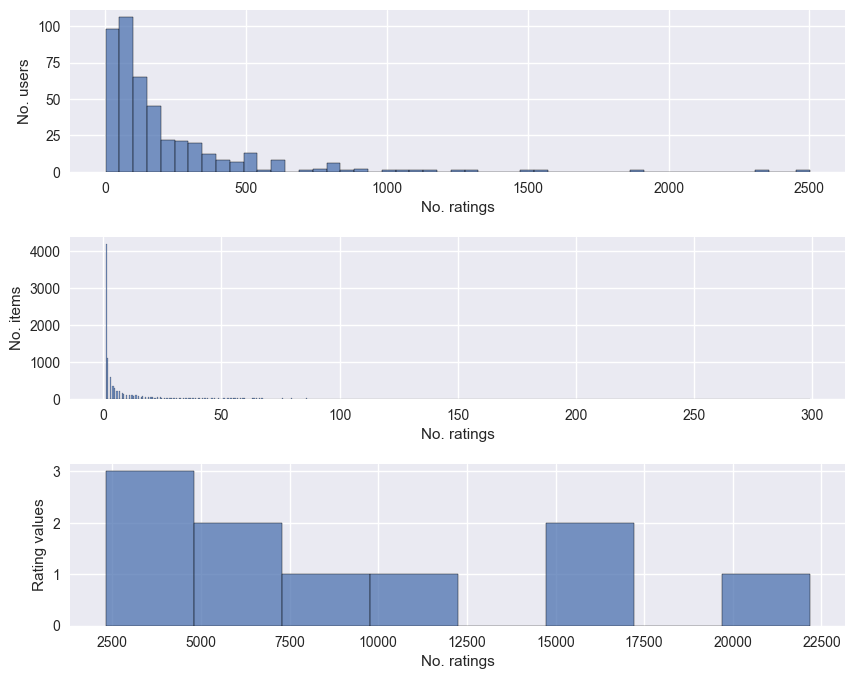

In [19]:
fig = plt.figure(figsize=(10, 8))
fig.subplots_adjust(hspace=0.4)

ax = fig.add_subplot(311)
sns.histplot(df_rating.groupby('user_id').count()['rating'], ax=ax)
ax.set_xlabel("No. ratings")
ax.set_ylabel("No. users")

ax = fig.add_subplot(312)
sns.histplot(df_rating.groupby('item_id').count()['rating'], ax=ax)
ax.set_xlabel("No. ratings")
ax.set_ylabel("No. items")

ax = fig.add_subplot(313)
sns.histplot(df_rating.groupby('rating').count()['user_id'], bins=8)
ax.set_xlabel("No. ratings")
ax.set_ylabel("Rating values")

## Task 2

### Split train-test (80 - 20)

In [8]:
trains, tests = [], []

for user_id in df_rating['user_id'].unique():
    df_uid = df_rating[df_rating['user_id'] == user_id]

    msk = np.random.rand(len(df_uid)) < 0.8

    df_train_, df_test_ = df_uid[msk], df_uid[~msk]

    trains.append(df_train_)
    tests.append(df_test_)


In [9]:
df_train, df_test = pd.concat(trains), pd.concat(tests)

### Form scores for random

In [10]:
indices = df_train['item_id'].unique()
np.random.shuffle(indices)

scores_random = pd.Series(
    np.arange(1, len(indices) + 1),
    index=indices
)

### Form scores for popularity

In [11]:
scores_popularity = df_train.groupby('item_id').count()['rating']

In [12]:
def get_score_random(list_item_ids: list) -> list:
    scores = [scores_random[i] if i in scores_random.index else 0 for i in list_item_ids]

    return scores

def get_score_popularity(list_item_ids: list) -> list:
    scores = [scores_popularity[i] if i in scores_popularity.index else 0 for i in list_item_ids]

    return scores


## Task 3

In [13]:
item_ids_total = set(df_rating['item_id'].unique())

def get_uniform_negative_sample(user_id: int, n_samples: int = 100):
    item_ids_rated = set(df_rating[df_rating['user_id'] == user_id]['item_id'].unique())
    non_rated = item_ids_total.difference(item_ids_rated)

    neg_samples = np.random.choice(list(non_rated), min(n_samples, len(non_rated)), replace=False)

    return neg_samples

In [14]:
def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(1, r.size + 1) + 1))
    return 0.
def ndcg_at_k(r, k):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k) / dcg_max

In [15]:
K = 5
N_NEG_SAMPELS = 100

ndcg_random, ndcg_popularity = [], []

for user_id in df_test['user_id'].unique():
    # Get rows in test set
    df_test_user = df_test[df_test['user_id'] == user_id].drop(columns=['user_id'])

    items = df_test_user['item_id']
    items_neg = get_uniform_negative_sample(user_id, n_samples=N_NEG_SAMPELS)
    df_items_neg = pd.DataFrame({'item_id': items_neg, 'rating': np.zeros_like(items_neg)})

    df_test_user = pd.concat([df_test_user, df_items_neg])

    df_test_user['scores_random'] = get_score_random(df_test_user['item_id'])
    df_test_user['scores_popularity'] = get_score_popularity(df_test_user['item_id'])

    ndcg_random_user= ndcg_at_k(df_test_user.sort_values('scores_random', ascending=False)['rating'], K)
    ndcg_popularity_user = ndcg_at_k(df_test_user.sort_values('scores_popularity', ascending=False)['rating'], K)
    
    ndcg_random.append(ndcg_random_user)
    ndcg_popularity.append(ndcg_popularity_user)

print(f"Mean: NDCG@{K} of Random    : {np.mean(ndcg_random).item():.4f}")
print(f"Mean: NDCG@{K} of Popularity: {np.mean(ndcg_popularity).item():.4f}")

Mean: NDCG@5 of Random    : 0.2009
Mean: NDCG@5 of Popularity: 0.7535


## Task 4

In [16]:
path_meta = "week1/dataset/metadata.csv"

df_meta = pd.read_csv(path_meta)

df_meta.head()

,title,directedBy,starring,imdbId,item_id
0,Jumanji (1995),Joe Johnston,"Jonathan Hyde, Bradley Pierce, Robin Williams,...",113497,2
1,Grumpier Old Men (1995),Howard Deutch,"Jack Lemmon, Walter Matthau, Ann-Margret , Sop...",113228,3
2,Waiting to Exhale (1995),Forest Whitaker,"Angela Bassett, Loretta Devine, Whitney Housto...",114885,4
3,Sabrina (1995),Sydney Pollack,"Harrison Ford, Greg Kinnear, Nancy Marchand, J...",114319,7
4,Sudden Death (1995),Peter Hyams,"Raymond J. Barry, Powers Boothe, Jean-Claude V...",114576,9


In [17]:
top10_items = scores_popularity.sort_values(ascending=False)[:10].index

In [18]:
df_meta[df_meta['item_id'].isin(top10_items)]

,title,directedBy,starring,imdbId,item_id
98,Star Wars: Episode IV - A New Hope (1977),George Lucas,"Mark Hamill, Harrison Ford, Carrie Fisher, Pet...",76759,260
113,Pulp Fiction (1994),Quentin Tarantino,"John Travolta, Samuel L. Jackson, Tim Roth, Am...",110912,296
121,"Shawshank Redemption, The (1994)",Frank Darabont,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",111161,318
137,Forrest Gump (1994),Robert Zemeckis,"Tom Hanks, Gary Sinise, Mykelti Williamson, Ro...",109830,356
213,Blade Runner (1982),Ridley Scott,"Harrison Ford, Rutger Hauer, Sean Young, Edwar...",83658,541
229,"Silence of the Lambs, The (1991)",Jonathan Demme,"Jodie Foster, Anthony Hopkins, Scott Glenn, An...",102926,593
402,Star Wars: Episode V - The Empire Strikes Back...,Irvin Kershner,"Mark Hamill, Harrison Ford, Carrie Fisher, Bil...",80684,1196
404,Raiders of the Lost Ark (Indiana Jones and the...,Steven Spielberg,"Harrison Ford, Karen Allen, Paul Freeman, John...",82971,1198
2192,"Lord of the Rings: The Return of the King, The...",Peter Jackson,"Sean Astin, Ian McKellen, Viggo Mortensen, Eli...",167260,7153
3537,"Dark Knight, The (2008)",Christopher Nolan,"Christian Bale, Aaron Eckhart, Heath Ledger, M...",468569,58559
